In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

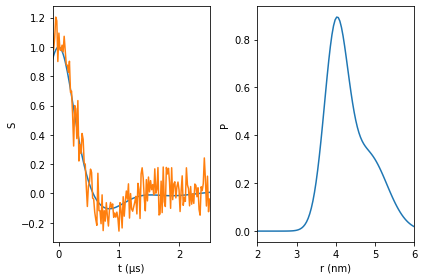

In [2]:
nr = 100
nt = 150

t = np.linspace(-0.1,2.5,nt)        # time axis, µs
r = np.linspace(2,6,nr)      # distance axis, ns

r0 = 4 
fwhm = 0.4 # parameters for three-Gaussian model
P0 = dive.dd_gauss(r,r0,fwhm)          # model distance distribution

param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
P0 = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dive.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r)    # kernel matrix
sigma = 0.1

S0 = K@P0
S = S0 + dl.whitegaussnoise(t,sigma,seed=0)

# Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, P0)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [2,6], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

## Draw a sample:

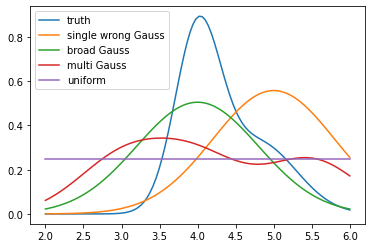

In [3]:
param = [5, 0.8] # parameters for three-Gaussian model
PsingleGaussOff = dl.dd_gauss(r,param)          # model distance distribution

param = [4, 0.8] # parameters for three-Gaussian model
PbroadGauss = dl.dd_gauss(r,param)          # model distance distribution

param3 = [4, 0.6,0.3, 3, 0.6, 0.3, 5.5, 0.6, 0.3] # parameters for three-Gaussian model

PmultiGauss = dl.dd_gauss3(r,param3)          # model distance distribution

param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
P2G = dl.dd_gauss2(r,param2)  

Puniform = np.ones(r.shape)
Puniform = Puniform/sum(Puniform)/(r[1]-r[0])

plt.plot(r, P0, label = "truth")
plt.plot(r, PsingleGaussOff, label = "single wrong Gauss")
plt.plot(r, PbroadGauss, label = "broad Gauss")
plt.plot(r, PmultiGauss, label = "multi Gauss")
plt.plot(r, Puniform, label = "uniform")
plt.legend();

In [4]:
Pmap = P0

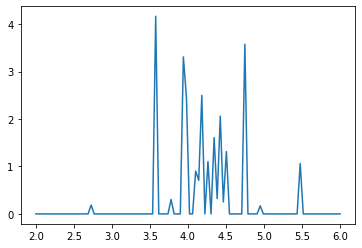

In [5]:
KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

invSigma = (KtK+LtL)
Sigma = np.linalg.inv(invSigma)
C_L = np.linalg.cholesky(Sigma)

delta_ = 0.05
tau_ = 100

P_ = dive.randP(delta_,tau_*KtK,tau_*KtS,LtL,nr)

plt.plot(r,P_);

In [6]:
# if true:
#     delta_init = 1^2*tau
#     %P_init needs to be a randomized draw so that norm(LP) is about the right size.
#     P_init = randP(delta_init,tauKtK,tauKtS,LtL,nt);
#     a0 = 1;
#     b0 = (1+nt/2)/delta_init - 0.5*norm(L*P_init)^2;
# else:
a0 = 0.01
b0 = 1e-6

# tau = 1/(sigma**2)
# alpha = comes from regularization solution
# delta_init = alpha^2*tau
# P_init = randP(delta_init,tauKTK,tauKtS,LtL,nr)

P_init = Pmap

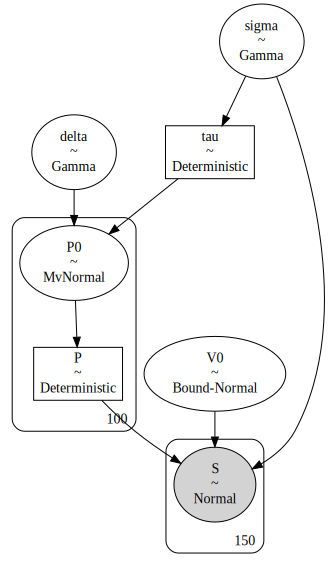

In [7]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)

    tau = pm.Deterministic('tau',1/(sigma**2))

    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # DEER Signal
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    Smodel = pm.math.dot(K,P)
    pm.Normal('S',mu = V0*Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [8]:
from pymc3.step_methods.arraystep import BlockedStep

class SampleRandP(BlockedStep):
    def __init__(self, var, delta, sigma, KtK, KtS, LtL, nr):
            self.vars = [var]
            self.var = var
            self.delta = delta
            self.sigma = sigma
            self.KtK = KtK
            self.KtS = KtS
            self.LtL = LtL
            self.nr = nr

    def step(self, point: dict):
        new = point.copy()
        sigma = np.exp(point[self.sigma.transformed.name])
        # sigma = 0.01
        tau = 1/(sigma**2)
        delta = np.exp(point[self.delta.transformed.name])
       
        # debugging
        # tau = 100
        # delta = 0.05
        new[self.var.name] = dive.randP(delta,tau*self.KtK,tau*self.KtS,self.LtL,self.nr)

        return new

In [9]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

sigma_log__ -1.2105397072887791
delta_log__ -4.655531579901904
P0 369.8099193767731
V0_lowerbound__ 0.6904993792294276
S 13.159878818777713


In [10]:
with model:
    step_P0 = SampleRandP(P0, delta, sigma, KtK, KtS, LtL, nr)  
    trace = pm.sample(step = step_P0, chains=4, cores=1, draws=10000, tune=5000,return_inferencedata=False)

# with model:
#     step = pm.sample(chains=1, cores=1, draws=6000, tune=3000,return_inferencedata=True,start = {'P0' : P_init})

Sequential sampling (4 chains in 1 job)
CompoundStep
>SampleRandP: [P0]
>NUTS: [V0, delta, sigma]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 1595 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8867097706306007, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9166978527228186, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V₀,1.123,0.035,1.057,1.186,0.000,0.000,24697.0,23630.0,1.0
σ,0.105,0.007,0.093,0.119,0.000,0.000,16820.0,19852.0,1.0
τ,91.545,12.029,68.931,113.608,0.092,0.065,16820.0,19852.0,1.0
δ,311.553,120.883,110.539,532.768,2.092,1.480,3159.0,6371.0,1.0


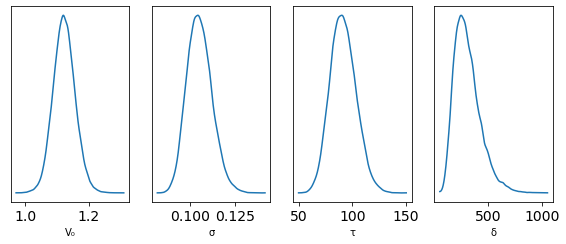

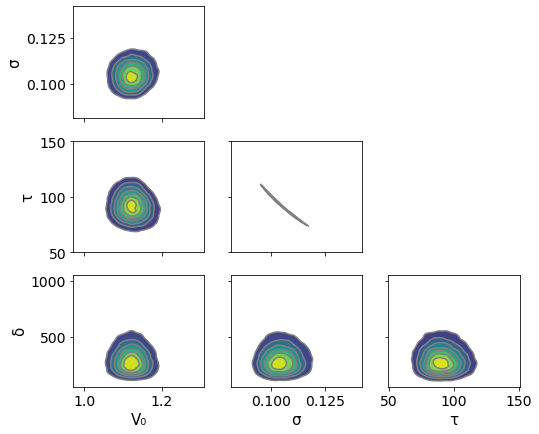

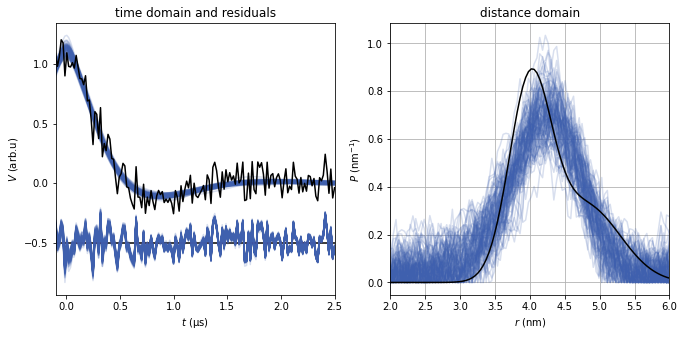

In [18]:
dive.summary(trace, model, S, t, r, Ptrue = Pmap)